# Recursive Forecasting with future known features

[Forecasting with Machine Learning - Course](https://www.trainindata.com/p/forecasting-with-machine-learning)

In this notebook, we carry out recursive forecasting to predict multiple steps into the future by using a Lasso regression.

SKForecast produces lags out of the box. But we can combine SKForecast with Feature-engine and other libraries to create more features.

In this notebook, we will add features whose values in the future we know: **features about date and time.**

In [1]:
import matplotlib.pyplot as plt
import pandas as pd

from sklearn.linear_model import Lasso
from sklearn.metrics import mean_squared_error
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler

from skforecast.ForecasterAutoreg import ForecasterAutoreg

from feature_engine.datetime import DatetimeFeatures

# Load data

We will use the electricity demand dataset found [here](https://github.com/tidyverts/tsibbledata/tree/master/data-raw/vic_elec/VIC2015).

**Citation:**

Godahewa, Rakshitha, Bergmeir, Christoph, Webb, Geoff, Hyndman, Rob, & Montero-Manso, Pablo. (2021). Australian Electricity Demand Dataset (Version 1) [Data set]. Zenodo. https://doi.org/10.5281/zenodo.4659727

**Description of data:**

A description of the data can be found [here](https://rdrr.io/cran/tsibbledata/man/vic_elec.html). The data contains electricity demand in Victoria, Australia, at 30 minute intervals over a period of 12 years, from 2002 to early 2015. There is also the temperature in Melbourne at 30 minute intervals and public holiday dates.

In [2]:
# Electricity demand.
url = "https://raw.githubusercontent.com/tidyverts/tsibbledata/master/data-raw/vic_elec/VIC2015/demand.csv"
df = pd.read_csv(url)

df.drop(columns=["Industrial"], inplace=True)

# Convert the integer Date to an actual date with datetime type
df["date"] = df["Date"].apply(
    lambda x: pd.Timestamp("1899-12-30") + pd.Timedelta(x, unit="days")
)

# Create a timestamp from the integer Period representing 30 minute intervals
df["date_time"] = df["date"] + \
    pd.to_timedelta((df["Period"] - 1) * 30, unit="m")

df.dropna(inplace=True)

# Rename columns
df = df[["date_time", "OperationalLessIndustrial"]]

df.columns = ["date_time", "demand"]

# Resample to hourly
df = (
    df.set_index("date_time")
    .resample("H")
    .agg({"demand": "sum"})
)

df.head()

,demand
date_time,
2002-01-01 00:00:00,6919.366092
2002-01-01 01:00:00,7165.974188
2002-01-01 02:00:00,6406.542994
2002-01-01 03:00:00,5815.537828
2002-01-01 04:00:00,5497.732922


In [3]:
df.tail()

,demand
date_time,
2015-02-28 19:00:00,9596.777060
2015-02-28 20:00:00,8883.230296
2015-02-28 21:00:00,8320.260550
2015-02-28 22:00:00,8110.055916
2015-02-28 23:00:00,8519.368752


In [4]:
# Split into train and test

# We leave the last February in the test set

end_train = '2014-12-31 23:59:59'
X_train = df.loc[:end_train]
X_test  = df.loc[end_train:]

## Plot time series

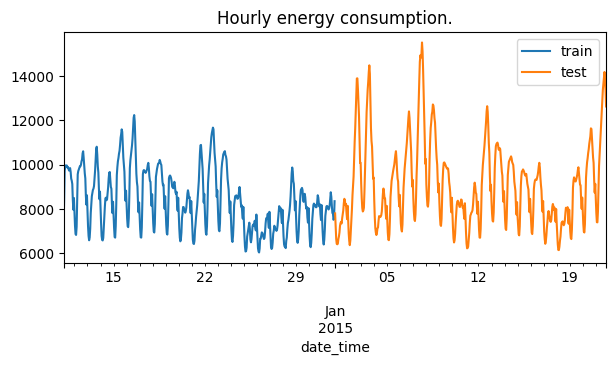

In [5]:
fig, ax = plt.subplots(figsize=(7, 3))
X_train.tail(500).plot(ax=ax)
X_test.head(500).plot(ax=ax)
ax.set_title('Hourly energy consumption.')
ax.legend(["train", "test"])
plt.show()

## Regression model

In [6]:
# Lasso regression model
# datetime and energy demand are not in the
# same scale, so we need to scale the variables

model = Pipeline([
    ("scaler", MinMaxScaler()),
    ("lasso", Lasso(random_state=9, alpha=10))
])

## Adding datetime features

Let's now do recursive forecasting adding datetime features.

In [7]:
# Feature engine's transformer to create datetime
# features can extract features from one or more columns
# or from the index.

# To be compatible with skforecast, we need to extract
# features from a column, and ensure the result does not contain
# any variables that we do not want as part of the forecast.

datetime_f = DatetimeFeatures(
    features_to_extract = ["month", "day_of_week", "hour"],
    drop_original=True,
)

In [8]:
# the input to the datetime features

datetime_df = pd.DataFrame(
    X_train.index,
    index=X_train.index,
)

# the index needs to match with the series we
# want to forecast

datetime_df

,date_time
date_time,
2002-01-01 00:00:00,2002-01-01 00:00:00
2002-01-01 01:00:00,2002-01-01 01:00:00
2002-01-01 02:00:00,2002-01-01 02:00:00
2002-01-01 03:00:00,2002-01-01 03:00:00
2002-01-01 04:00:00,2002-01-01 04:00:00
...,...
2014-12-31 19:00:00,2014-12-31 19:00:00
2014-12-31 20:00:00,2014-12-31 20:00:00
2014-12-31 21:00:00,2014-12-31 21:00:00


In [9]:
# test transformer

datetime_f.fit_transform(datetime_df)

,date_time_month,date_time_day_of_week,date_time_hour
date_time,,,
2002-01-01 00:00:00,1,1,0
2002-01-01 01:00:00,1,1,1
2002-01-01 02:00:00,1,1,2
2002-01-01 03:00:00,1,1,3
2002-01-01 04:00:00,1,1,4
...,...,...,...
2014-12-31 19:00:00,12,2,19
2014-12-31 20:00:00,12,2,20
2014-12-31 21:00:00,12,2,21


The output of the transformer is the datetime features that we want. That's good.

**Important**: make sure you don accidentally introduce any data that leaks information about the future!!!

Now, we can plug it into the forecaster:

In [10]:
forecaster = ForecasterAutoreg(
    regressor=model,              # the machine learning model
    lags=[1, 24, 6*24],           # the lag features to create
    transformer_exog=datetime_f,  # to get the datetime features
    forecaster_id="recursive"
)

In [11]:
# Fit the model to the data

forecaster.fit(
    y=X_train["demand"],  # the series for the lags
    exog=datetime_df,    # the datetime for the datetime features
)

forecaster

ForecasterAutoreg 
Regressor: Pipeline(steps=[('scaler', MinMaxScaler()),
                ('lasso', Lasso(alpha=10, random_state=9))]) 
Lags: [  1  24 144] 
Transformer for y: None 
Transformer for exog: DatetimeFeatures(features_to_extract=['month', 'day_of_week', 'hour']) 
Window size: 144 
Weight function included: False 
Differentiation order: None 
Exogenous included: True 
Type of exogenous variable: <class 'pandas.core.frame.DataFrame'> 
Exogenous variables names: ['date_time'] 
Training range: [Timestamp('2002-01-01 00:00:00'), Timestamp('2014-12-31 23:00:00')] 
Training index type: DatetimeIndex 
Training index frequency: H 
Regressor parameters: {'scaler__clip': False, 'scaler__copy': True, 'scaler__feature_range': (0, 1), 'lasso__alpha': 10, 'lasso__copy_X': True, 'lasso__fit_intercept': True, 'lasso__max_iter': 1000, 'lasso__positive': False, 'lasso__precompute': False, 'lasso__random_state': 9, 'lasso__selection': 'cyclic', 'lasso__tol': 0.0001, 'lasso__warm_start': False}

## Input features to regression

In [12]:
# Check the predictor features table created by skforecast.

# These are the input to the Lasso, so it's important to know
# what we are using for training:

X, y = forecaster.create_train_X_y(
    y=X_train["demand"],
    exog=datetime_df,
)

X, y

(                           lag_1       lag_24      lag_144  date_time_month  \
 date_time                                                                     
 2002-01-07 00:00:00  7290.234268  6722.984526  6919.366092                1   
 2002-01-07 01:00:00  6808.008916  7140.591176  7165.974188                1   
 2002-01-07 02:00:00  7209.285712  6562.022104  6406.542994                1   
 2002-01-07 03:00:00  6535.818342  5976.020780  5815.537828                1   
 2002-01-07 04:00:00  6112.382636  5688.468222  5497.732922                1   
 ...                          ...          ...          ...              ...   
 2014-12-31 19:00:00  8139.251100  8110.937760  7301.855388               12   
 2014-12-31 20:00:00  7818.461408  8214.038608  7472.779788               12   
 2014-12-31 21:00:00  7801.201802  7768.087674  7170.472868               12   
 2014-12-31 22:00:00  7516.472988  7504.257620  7038.967858               12   
 2014-12-31 23:00:00  7571.301440  8181.

That is the data **before** scaling.

`2002-01-07` was a Monday, to double check the `day of the week variable`.

In [13]:
# If we print the last points in the time series before 
# the starting point in the training set, # we can corroborate
# lag of 1. If we print further back, we can corroborate lag of 24 and so on

# the first points were dropped, because they contained the NAN values
# introduced by lag of 24 and lag of 144. So in short, the first 144 rows
# are dropped.

X_train.loc[:"2002-01-07 00:00:00"].tail()

,demand
date_time,
2002-01-06 20:00:00,7711.474702
2002-01-06 21:00:00,7125.291686
2002-01-06 22:00:00,6765.573884
2002-01-06 23:00:00,7290.234268
2002-01-07 00:00:00,6808.008916


## Forecast next 24 hs

We will predict the first points of energy demand right after the training set.

That is, starting `2015-01-01 00:00:00`.

In [14]:
# we need to create the table with datetime from
# which the datetime features will be created

datetime_df_test = pd.DataFrame(
    X_test.head(24).index,
    index=X_test.head(24).index,
)

# this date needs to coincide with the forecasting
# horizon
datetime_df_test.head()

,date_time
date_time,
2015-01-01 00:00:00,2015-01-01 00:00:00
2015-01-01 01:00:00,2015-01-01 01:00:00
2015-01-01 02:00:00,2015-01-01 02:00:00
2015-01-01 03:00:00,2015-01-01 03:00:00
2015-01-01 04:00:00,2015-01-01 04:00:00


In [15]:
# Predict the next 24 hs

predictions = forecaster.predict(
    steps=24,
    exog=datetime_df_test,
)

predictions.head()

2015-01-01 00:00:00    8157.531346
2015-01-01 01:00:00    7868.416403
2015-01-01 02:00:00    7550.127846
2015-01-01 03:00:00    7290.602361
2015-01-01 04:00:00    7146.930468
Freq: H, Name: pred, dtype: float64

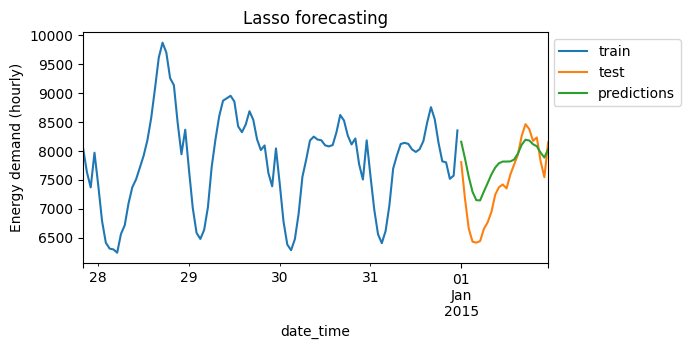

In [16]:
# Plot the forecast vs the actual

fig, ax = plt.subplots(figsize=(6, 3))
X_train.tail(100)["demand"].plot(ax=ax, label='train')
X_test.head(24)["demand"].plot(ax=ax, label='test')
predictions.plot(ax=ax, label='predictions')
plt.title("Lasso forecasting")
plt.ylabel("Energy demand (hourly)")
ax.legend(bbox_to_anchor=(1.3, 1.0));

In [17]:
# Prediction error

error_mse = mean_squared_error(
                y_true = X_test["demand"].head(24),
                y_pred = predictions
            )

print(f"Test error (mse): {error_mse}")

Test error (mse): 234147.61493222843


In [18]:
# Prediction error

error_rmse = mean_squared_error(
                y_true = X_test["demand"].head(24),
                y_pred = predictions,
                squared=True,
            )

print(f"Test error (rmse): {error_rmse}")

Test error (rmse): 234147.61493222843


## Predict any time point into the future

In [19]:
# Say we want to predict energy demand for 1st of February

forecast_start = '2015-02-01 00:00:00'

# we need the energy demand up to 144 hs before that point
past_data_available = X_test[:'2015-01-31 23:59:59'].tail(144)

# data in the past that we know at the point of forecast
past_data_available.head()

,demand
date_time,
2015-01-26 00:00:00,7492.984640
2015-01-26 01:00:00,6991.499378
2015-01-26 02:00:00,6595.584424
2015-01-26 03:00:00,6469.695590
2015-01-26 04:00:00,6597.029332


In [20]:
# we also need the datetime in the date range of the forecasting horizon.

# To make predictions `exog` must start one step ahead of `last_window`.

horizon = X_test['2015-01-31 23:59:59':].head(24)

datetime_df_test = pd.DataFrame(
    horizon.index,
    index=horizon.index,
)

datetime_df_test

,date_time
date_time,
2015-02-01 00:00:00,2015-02-01 00:00:00
2015-02-01 01:00:00,2015-02-01 01:00:00
2015-02-01 02:00:00,2015-02-01 02:00:00
2015-02-01 03:00:00,2015-02-01 03:00:00
2015-02-01 04:00:00,2015-02-01 04:00:00
2015-02-01 05:00:00,2015-02-01 05:00:00
2015-02-01 06:00:00,2015-02-01 06:00:00
2015-02-01 07:00:00,2015-02-01 07:00:00
2015-02-01 08:00:00,2015-02-01 08:00:00


In [21]:
predictions = forecaster.predict(
    steps=24,
    last_window=past_data_available["demand"],
    exog=datetime_df_test,
)

predictions.head()

2015-02-01 00:00:00    8047.858223
2015-02-01 01:00:00    7675.654879
2015-02-01 02:00:00    7299.062419
2015-02-01 03:00:00    7004.656039
2015-02-01 04:00:00    6838.612017
Freq: H, Name: pred, dtype: float64

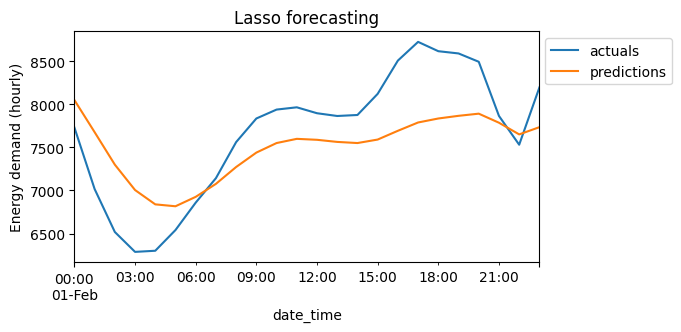

In [22]:
# Plot the forecast vs the actual

fig, ax = plt.subplots(figsize=(6, 3))
horizon["demand"].plot(ax=ax, label='actuals')
predictions.plot(ax=ax, label='predictions')
plt.title("Lasso forecasting")
plt.ylabel('Energy demand (hourly)')
ax.legend(bbox_to_anchor=(1.3, 1.0));

In [23]:
# Prediction error

error_mse = mean_squared_error(
                y_true = horizon,
                y_pred = predictions
            )

print(f"Test error (mse): {error_mse}")

Test error (mse): 266262.938369618


In [24]:
# Prediction error

error_rmse = mean_squared_error(
                y_true = horizon,
                y_pred = predictions,
                squared=False,
            )

print(f"Test error (rmse): {error_rmse}")

Test error (rmse): 516.0067231825744


## Feature importance

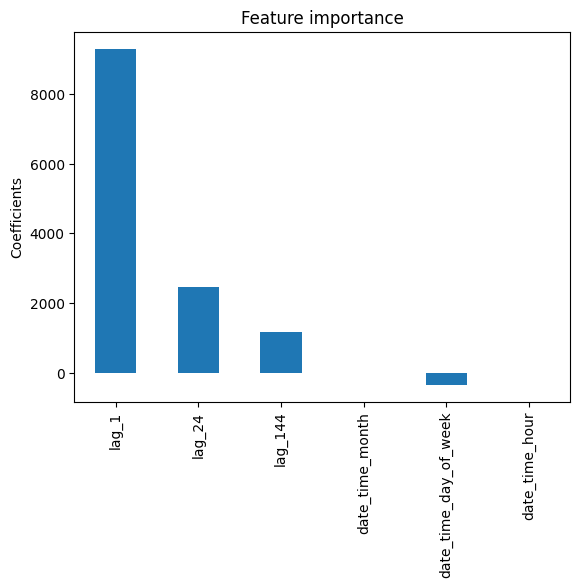

In [25]:
pd.Series(forecaster.regressor.named_steps["lasso"].coef_,
          index=forecaster.regressor.feature_names_in_).plot.bar()
plt.title('Feature importance')
plt.ylabel("Coefficients")
plt.show()